In [50]:
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import math
import einops as E
import random

In [102]:
class BatchStylesStandardization():
    """Implements Batch Styles Standardization. Given a
    batch of N images and their Fourier transforms,
    we manipulate the different amplitudes by
    substituting their low-frequency components
    with those a randomly chosen image.
    Attributes:
    ratios (tuple): $(r_min, r_max)$ specifying
    the minimum and maximum possible
    areas ratio between the substituted
    amplitude and the full amplitude.
    """
    def __init__(self, ratios):
        self.ratios = ratios
        
    def substitute_low_freq(self, src_amp, tgt_amp, ratio):
        """Substitute the low-frequency components
        of the source amplitudes with those
        of the target amplitudes.
        Args:
        src_amp (torch.Tensor): Source amplitudes
        tgt_amp (torch.Tensor): Target amplitudes
        ratio (float): Area ratio between the
        substituted amplitude and the full
        amplitude.
        Returns:
        torch.Tensor: Source amplitudes where
        the low-frequency components have been
        substituted with those
        of the target amplitudes.
        """
        # Compute center coordinates of amplitudes
        h, w = src_amp.shape[-2:]
        hc, wc = int(h//2), int(w//2)
        # Compute half length `l` of the components
        # to be substituted
        l = min([int(ratio*h/2), int(ratio*w/2)])
        # Substitute low freq components of source
        # amplitudes with those of the target amplitudes
        low_freq_tgt_amp = tgt_amp[
        ..., hc-l:hc+l, wc-l:wc+l]
        src_amp[
        ..., hc-l:hc+l, wc-l:wc+l] = low_freq_tgt_amp
        return src_amp

    def __call__(self, imgs, n_views):
        """Apply batch styles standardization `n_views` times
        on a batch of $N$ images.
        Args:
        imgs (torch.Tensor): Batch of images (N, 3, H, W)
        n_views (int): Number of augmented views
        Returns:
        torch.Tensor: Batch with standardized styles
        (N, n_views, 3, H, W)
        """
        # Apply FFT on source images
        fft = torch.fft.fftn(
        imgs, dim=(-2, -1))
        # Shift low-frequency components to the center
        fft = torch.fft.fftshift(
        fft, dim=(-2, -1))
        # Retrieve amplitude and phase
        amp, phase = fft.abs(), fft.angle()
        # Sample n_views images that will be used as
        # ref styles
        bs = imgs.size(0)
        sampled_ind = torch.arange(bs)[1:n_views+1]
        # Substitute low-freq of src amplitudes with those
        # of the n_views sampled images
        src_amp = amp.unsqueeze(1).repeat(
        [1, n_views, 1, 1, 1])
        tgt_amp = amp[sampled_ind].unsqueeze(0).expand(
        bs, -1, -1, -1, -1)
        sampled_ratio = random.uniform(*self.ratios)
        amp = self.substitute_low_freq(
        src_amp, tgt_amp, sampled_ratio)
        phase = phase.unsqueeze(1)
        # Reconstruct FFT from amp and phase
        fft = torch.polar(amp, phase)
        # Shift back low-frequency to their
        # original positions
        fft = torch.fft.ifftshift(fft, dim=(-2, -1))
        # Invert FFT
        imgs = torch.fft.ifftn(
            fft, dim=(-2, -1)).real.clamp(0, 1)

        return imgs

In [85]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

In [54]:
### Get support targets and labels

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    # transforms.Lambda(lambda x: x/255.),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

transform2 = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    # transforms.Lambda(lambda x: x/255.)
    # 1D Normalize
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

In [86]:
def sample_support(images_support,n=64):
    support = []
    labels = []
    for i in range(n):
        index = np.random.randint(len(images_support))
        support_img = transform(Image.open("./HAM10000_images_part_1/"+images_support[index]))
        label_img = transform2(Image.open("./Segmentation_masks/HAM10000_segmentations_lesion_tschandl/"+images_support[index][:-4] + "_segmentation.png"))
        support.append(support_img[:,:,:])
        labels.append(label_img[:,:,:])
    support = torch.stack(support)
    labels = torch.stack(labels)
    return support,labels

In [87]:
images_tot = os.listdir("./HAM10000_images_part_2/") + os.listdir("./HAM10000_images_part_1/")
label_tot = os.listdir("./Segmentation_masks/HAM10000_segmentations_lesion_tschandl/")

In [88]:
support = sample_support(images_tot,n=5)

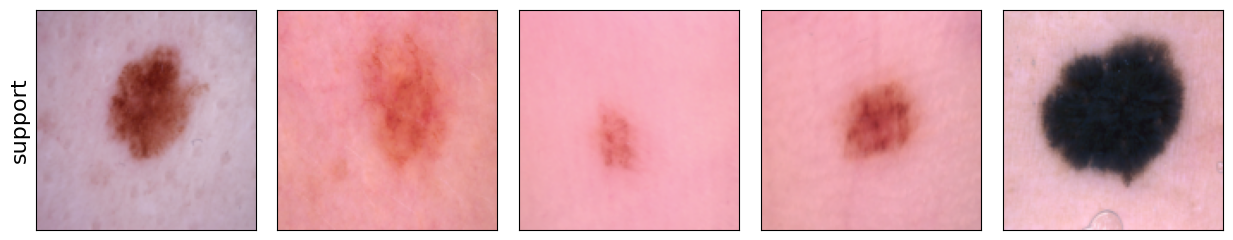

In [89]:
visualize_tensors({'support':support[0]},col_wrap=5)

In [103]:
model = BatchStylesStandardization(ratios=(0.1,0.9))

In [104]:
support_style = model(support[0],n_views=4)

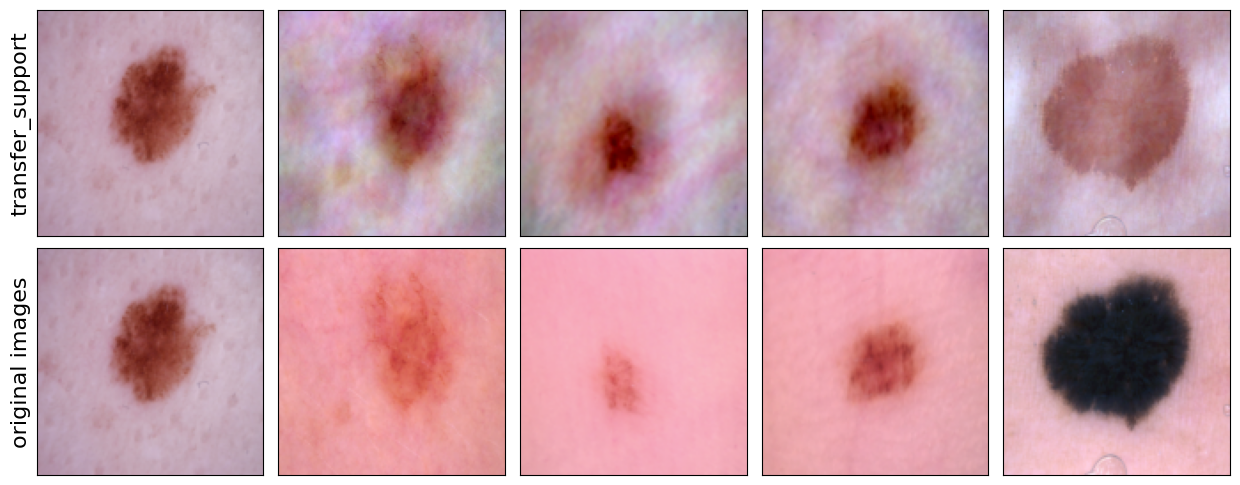

In [93]:
visualize_tensors({'transfer_support':support_style[:,0,:,:,:],
    'original images':support[0]
    },col_wrap=5)

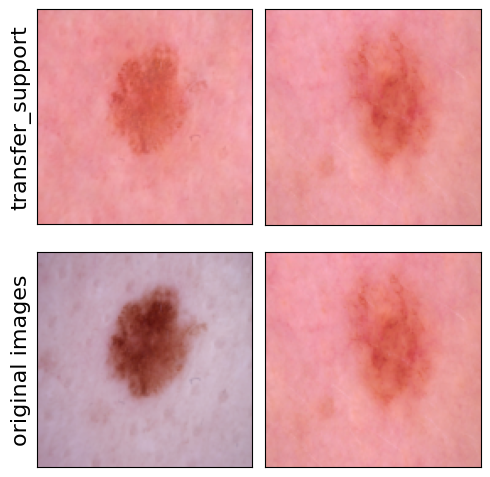

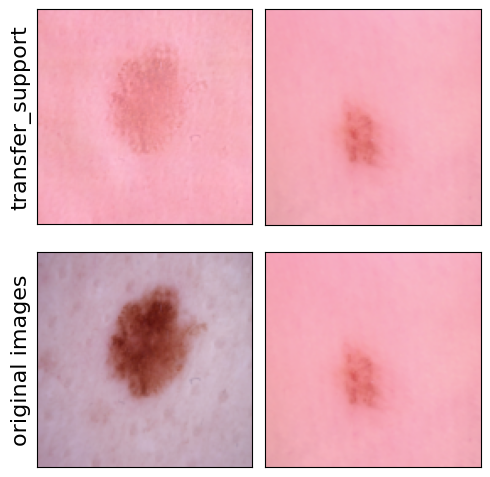

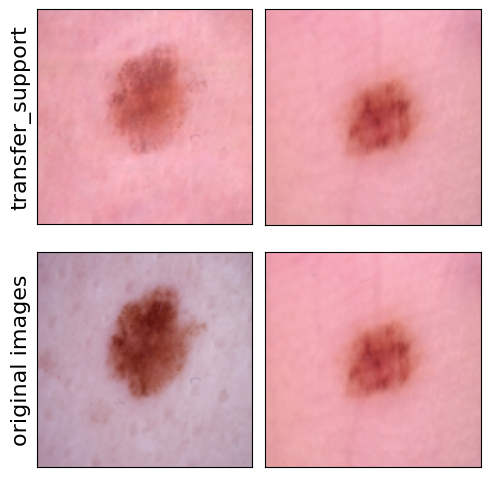

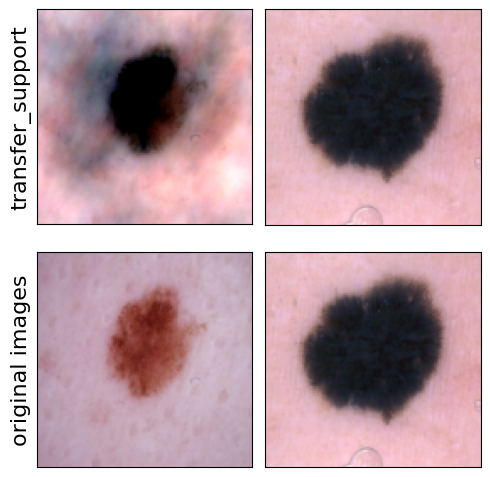

In [130]:
for _ in range(4):
    visualize_tensors({
        'transfer_support':support_style[(0,_+1),_,:,:,:],
        'original images':support[0][(0,_+1),:,:,:]
        },col_wrap=2)